In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval,SqrtStretch,ZScaleInterval,PercentileInterval,ImageNormalize)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch
from itertools import repeat
from matplotlib.colors import LogNorm
import os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import pickle

# Input and output files and directories 

In [2]:
inputdir = '/pbs/throng/lsst/users/mrodrigu/desc/AuxTelComm/notebookccdm_gen3/bouguerlines/2022_09/data/'

In [3]:
file_label = 'run-auxtel-holo-{0}-{1}~{2}-config_DECONVOLUTION_PSF1D.pickle'

In [4]:
outdir = './output_files/'
if os.path.exists(outdir)==False:
    os.mkdir(outdir)

In [5]:
outdir_plots = './output_plots/'
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots)

In [6]:
obs_date = '20220628'
filter = 'FELH0600'
disperser = 'holo4_003'

In [7]:
save_txt = True

In [8]:
inputfile = os.path.join(inputdir,file_label.format(obs_date,filter,disperser))

# Define functions 
Old definitions 

In [9]:
def lin_fun(x,a,b):
    return a*x+b

In [10]:
def fun_fit(x,a,b,c,d):
    return a*x**3.+b*x**2.+c*x+d

In [11]:
#def continuum_error(l0,sigma_a,sigma_b,sigma_c,sigma_d):
#    return np.sqrt(l0**6.*sigma_a**2.+l0**4.*sigma_b**2.+l0**2.*sigma_c**2.+sigma_d**2.)

EQW errors: 

We characterise the continuum by an $n$-order polynomial, 

$$ C(\lambda) = \sum_{k=0}^n a_k \lambda^k \, .$$ 

Then, its error is given by 

$$ \sigma^2_{C(\lambda)} = \sum_{k=0}^n \lambda^{2k} \sigma^2_{a_k} + 2 \cdot \sum_{i=0}^n \sum_{j>i} \lambda^i \lambda^j cov(a_i,a_j) \, . $$

In [12]:
def continuum_error(l0,cov,use_cov=False):
    order = len(np.diagonal(cov))-1
    
    error = 0.0
    for k in range(order+1):
        order_ = order-k
        error = error+np.power(l0,2*order_)*cov[k,k]
    if use_cov:
        for i in range(order+1):
            order_i = order-i
            for j in range(order+1):
                if j>i:
                    order_j = order-j
                    error = error+2.*np.power(l0,order_i)*np.power(l0,order_j)*cov[i,j]
    
    return np.sqrt(error)

The error of the integral under the line is given by 

$$ A_{UL} = \int_{\lambda_{min}}^{\lambda_{max}} SED(\lambda) \, d\lambda \rightarrow A_{ul} \simeq \sum_i SED_i \, \Delta \lambda \, , $$ 

with $SED_i = SED(\lambda_i)$ and where we assume that $\Delta \lambda_i \simeq \Delta \lambda \, \forall \, i$. Then, the error is given by 

$$ \sigma^2_{A_{UL}} \simeq \sum_i \sigma^2_{SED_i} \, \Delta \lambda^2 \, . $$ 

In this case, $\sigma^2_{SED_i}$ is given by Spectractor. 

In [13]:
def area_ul_error(flux_error,lambda_vec):
    delta_lambda = np.mean(np.diff(lambda_vec))
    return np.sqrt(np.sum(flux_error**2.)*delta_lambda**2.)

The area contained by the line, that is, the area between the absorption line and the estimated continuum, is 

$$ A_L = A_C - A_{UL} \, . $$ 

Then, its error is 

$$ \sigma^2_{A_L} = \sigma^2_{A_C} + \sigma^2_{A_{UL}} \, . $$ 

Here, we use as the error of the area below the continuum (that is, $\int C(\lambda) \, d\lambda$), $\sigma_{A_C}$, that given by python. 

In [14]:
def area_l_error(sigma_area_cont,sigma_area_ul):
    return np.sqrt(sigma_area_cont**2.+sigma_area_ul**2.)

The equivalent width, EQW, is given by 

$$ EQW = \frac{A_L}{h} \, , $$ 

where $h = C(\lambda_0)$, with $\lambda_0$ is the central wavelength of the line. Then, its error is 

$$ \sigma^2_{EQW} = \left( \frac{1}{h} \right)^2 \sigma^2_{A_L} + \left( \frac{A_L}{h^2} \right)^2 \sigma^2_h \, . $$ 

Here, $\sigma_h$ is calculated as 

$$ \sigma^2_h = \left. \sigma^2_{C(\lambda)}\right|_{\lambda_0} \, . $$ 

In [15]:
def eqw_error(cont_at_line,line_area,sigma_cont,sigma_area_line):
    sigma2_eqw = sigma_area_line**2./cont_at_line**2. + line_area**2.*sigma_cont**2./cont_at_line**4.
    return np.sqrt(sigma2_eqw)

In [16]:
def eqw(x,flux,min_cont,max_cont,min_lin,max_lin,central_lambda=None,n_order=1,return_fit=False,make_plot=True,plot_name='test.png'): 
    
    xmask_c = (x>=min_cont)*(x<=max_cont)
    xmask_fit = (x>=min_cont)*(x<=min_lin)+(x<=max_cont)*(x>=max_lin)
    
    
    xline = x[xmask_c]
    fline = flux[xmask_c]
    
    xc1 = x[xmask_fit]
    yc1 = flux[xmask_fit]

    xc2 = x[xmask_fit]
    yc2 = flux[xmask_fit]
    
    xc3 = np.concatenate((xc1,xc2))
    yc3 = np.concatenate((yc1,yc2))
    
    #p3,cov3 = curve_fit(fun_fit,xc3,yc3)
    p_,cov_ = np.polyfit(xc3,yc3,n_order,cov=True)
    pol_ = np.poly1d(p_)
        
    linemask = (xline>=min_lin)*(xline<=max_lin)
    xline_model = xline[linemask]
    #fline_model = fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3])
    fline_model = pol_(xline_model)
    
    def fun_fit_(x):
        return fun_fit(x,p3[0],p3[1],p3[2],p3[3])
    
    #norm_array = fun_fit_(xline)
    
    #area_c = np.trapz(fline_model,xline_model)
    #area_c, area_c_error = quad(fun_fit_,min_lin,max_lin)
    area_c, area_c_error = quad(pol_,min_lin,max_lin)
    area_ul = np.trapz(fline[linemask],xline_model)
    
    area_l = area_c-area_ul
    
    if central_lambda==None:
        xmin_line = xline_model[np.where(fline[linemask]==np.min(fline[linemask]))[0]][0]
        delta_line = 0.
        #print(xmin_line)
    else:
        xmin_line = central_lambda
        xmin_line_ = xline_model[np.where(fline[linemask]==np.min(fline[linemask]))[0]][0]
        delta_line = xmin_line_-central_lambda
    #cont_min = fun_fit(xmin_line,p3[0],p3[1],p3[2],p3[3])
    cont_min = pol_(xmin_line)
    
    eqw = area_l/cont_min
    #print('EQW = ',eqw)
    
    eqwmask = (xline_model>=xmin_line-eqw/2.)*(xline_model<=xmin_line+eqw/2.)
    continuum = np.ones(len(fline_model[eqwmask]))*cont_min
    
    if make_plot:
        fig=plt.figure(figsize=(10,6))
        plt.plot(xline,fline)
        #plt.plot(xline,fun_fit(xline,p3[0],p3[1],p3[2],p3[3]),ls='--',color='orange')
        plt.plot(xline,pol_(xline),ls='--',color='orange')
        #plt.fill_between(xline_model,fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3]),fline[linemask],color='gray',alpha=0.2)
        plt.fill_between(xline_model,pol_(xline_model),fline[linemask],color='gray',alpha=0.2)
        plt.fill_between(xline_model[eqwmask],continuum,color='cyan',alpha=0.2)
        plt.axvline(x=central_lambda,ls='--',color='r')
        plt.grid()
        plt.xlabel(r'$\lambda \, [nm]$',fontsize=12)
        #plt.ylabel(r'$\gamma \, / \, (s \cdot cm^2 \cdot nm)$',fontsize=12)
        
        plot_outdir = 'output_plots/'
        if os.path.exists(plot_outdir)==False:
            os.mkdir(plot_outdir)
        plt.savefig(plot_outdir+plot_name) 
        
    if return_fit:
        #return eqw, p3, cov3, xline, fline, fun_fit(xline,p3[0],p3[1],p3[2],p3[3]), fun_fit(xline_model,p3[0],p3[1],p3[2],p3[3]), linemask, xline_model[eqwmask], cont_min, area_l, area_c_error, continuum
        return eqw, p_, cov_, xline, fline, pol_(xline), pol_(xline_model), linemask, xline_model[eqwmask], cont_min, area_l, area_c_error, continuum
    else:
        return eqw
    

# Load spectra file 

In [17]:
with open(inputfile,'rb') as f:
    spec_dict = pickle.load(f)

In [18]:
#for key in spec_dict.keys():
#    print(spec_dict[key]['number'])

# Remove bad images from list 

In [19]:
bad_spec_dict = {'20220628':[171,223,250,251,400,425,479,480,538,593,654,655,656,657,683,708],
                 '20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593]}

In [20]:
bad_spec = bad_spec_dict[obs_date]

In [21]:
spec_dict_good = {}
for key in spec_dict.keys():
    if int(spec_dict[key]['number']) not in bad_spec:
        spec_dict_good[key] = spec_dict[key]

# Set theoretical position of the line 

In [22]:
line_lambda = 762.

# Load an example to estimate the line and continuum integration regions 

In [23]:
ref_obs = 'exposure_2022062800143_postisrccd_spectrum.fits'

In [24]:
lambda_ref = spec_dict_good[ref_obs]['all_lambdas']
flux_ref = spec_dict_good[ref_obs]['all_fluxes']

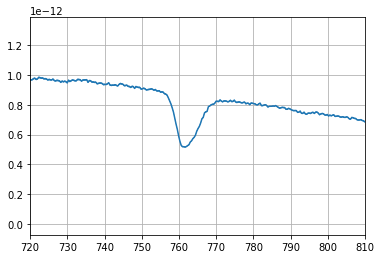

In [25]:
plt.plot(spec_dict_good[ref_obs]['all_lambdas'],spec_dict_good[ref_obs]['all_fluxes'])
plt.fill_between(spec_dict_good[ref_obs]['all_lambdas'],spec_dict_good[ref_obs]['all_fluxes']-spec_dict_good[ref_obs]['all_fluxes_err'],spec_dict_good[ref_obs]['all_fluxes']+spec_dict_good[ref_obs]['all_fluxes_err'])
plt.xlim(720,810)
plt.grid()

In [26]:
min_cont = 735
max_cont = 790
min_lin = 750
max_lin = 775

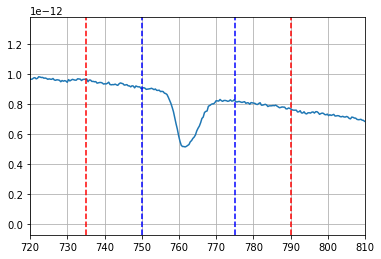

In [27]:
plt.plot(spec_dict_good[ref_obs]['all_lambdas'],spec_dict_good[ref_obs]['all_fluxes'])
plt.xlim(720,810)
plt.axvline(x=min_cont,color='r',ls='--')
plt.axvline(x=max_cont,color='r',ls='--')
plt.axvline(x=min_lin,color='b',ls='--')
plt.axvline(x=max_lin,color='b',ls='--')
plt.grid()
plt.savefig(outdir_plots+'line_ranges.png')

In [28]:
n_order = 1

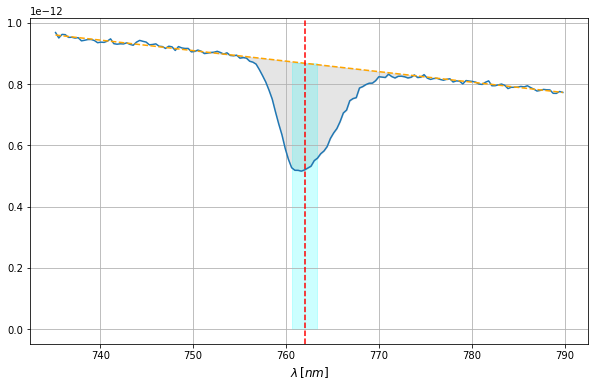

In [29]:
#eqw, params, x, fl = eqw(x_,specdf_ref,xmask_c,xmin_int,xmax_int,xmin_line)
eqw_val = eqw(lambda_ref,flux_ref,min_cont,max_cont,min_lin,max_lin,central_lambda=line_lambda,n_order=n_order,plot_name='eqw_line_fit_example.png')

# Iterate over all available images (both with and without flat-fielding) 

In [30]:
airmass = []
pressure = []
eqwidth = []
eqwidth_err = []
name = []
for spec in spec_dict_good:
    #print(spec)
    airmass_ = spec_dict_good[spec]['airmass']
    pressure_ = spec_dict_good[spec]['pressure']
    
    lambda_ = spec_dict_good[spec]['all_lambdas']
    flux_ = spec_dict_good[spec]['all_fluxes']
    flux_err_ = spec_dict_good[spec]['all_fluxes_err']
    #print(lambda_)
    #print(flux_)
    
    eqw_, p, cov, xline, fline, ffit, ffit_model, linemask, xcontinuum, cont_at_line, area_l_, area_c_err_, continuum = eqw(lambda_,flux_,min_cont,max_cont,min_lin,max_lin,central_lambda=line_lambda,n_order=n_order,make_plot=False,return_fit=True)
    
    #print(cont_at_line)
    #print(area_l_)
    
    #print(area_c_err_)
    #cont_err_ = continuum_error(line_lambda,sigma_a,sigma_b,sigma_c,sigma_d)
    cont_err_ = continuum_error(line_lambda,cov,use_cov=True)
    #print(cont_err_)
    area_ul_err_ = area_ul_error(flux_err_,lambda_)
    #print(area_ul_err_)
    area_l_err_ = area_l_error(area_c_err_,area_ul_err_)
    #print(area_l_err_)
    eqw_err_ = eqw_error(cont_at_line,area_l_,cont_err_,area_l_err_)
    #print(eqw_err_)
    #print('----------')
    
    airmass.append(airmass_)
    pressure.append(pressure_)
    eqwidth.append(eqw_)
    eqwidth_err.append(eqw_err_)
    name.append(spec)
airmass = np.array(airmass)
pressure = np.array(pressure)
eqwidth = np.array(eqwidth)
eqwidth_err = np.array(eqwidth_err)
if save_txt:
    data = np.transpose(np.array([airmass,pressure,eqwidth,eqwidth_err]))
    np.savetxt(os.path.join(outdir,'eqw_data_{0}_{1}_{2}.txt'.format(obs_date,filter,disperser)),data,header='airmass pressure eqw eqw_err')

In [31]:
print(eqwidth_err)

[0.0629241  0.06307388 0.06319814 0.06310866 0.06319687 0.06292161
 0.06145967 0.06214358 0.0622303  0.06174622 0.06317599 0.06250633
 0.06315231 0.06294857 0.06275285 0.04999392 0.05010827 0.04954525
 0.02412163 0.02418304 0.02407612 0.02506471 0.0244519  0.02376212
 0.02445393 0.02444429 0.02415177 0.0241175  0.02435426 0.02409084
 0.02423233 0.02400499 0.02373931 0.02415272 0.02397781 0.02361274
 0.02363405 0.02398351 0.02380547 0.02370295 0.02414056 0.02374136
 0.02368698 0.02377692 0.02349468 0.02410343 0.02343598 0.04941773
 0.04936487 0.05153059 0.05144724 0.05132694 0.04945135]


# Plot EQW as a function of airmass / pressure / airmass x pressure 

Text(0, 0.5, 'EQW [nm]')

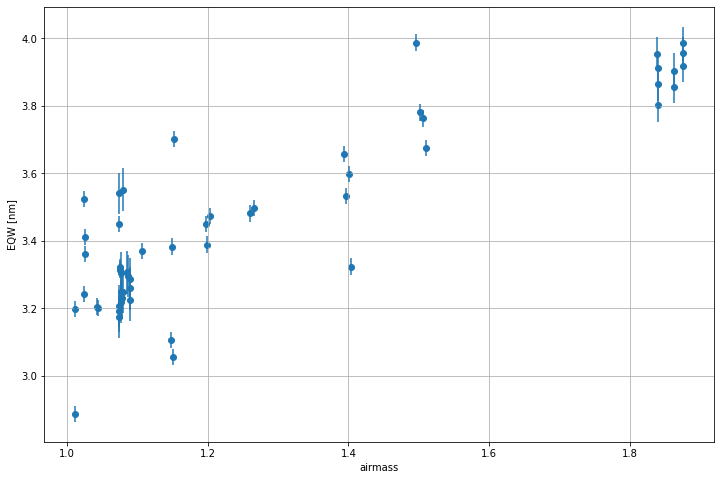

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(airmass,eqwidth)
plt.errorbar(airmass,eqwidth,yerr=eqwidth_err,ls='',fmt='.')
plt.grid()
plt.xlabel('airmass')
plt.ylabel('EQW [nm]')

Text(0, 0.5, 'EQW [nm]')

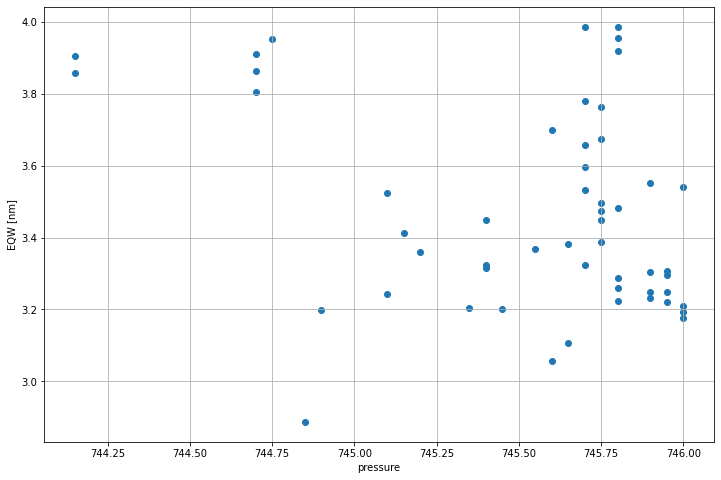

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(pressure,eqwidth)
plt.grid()
plt.xlabel('pressure')
plt.ylabel('EQW [nm]')

Text(0, 0.5, 'EQW [nm]')

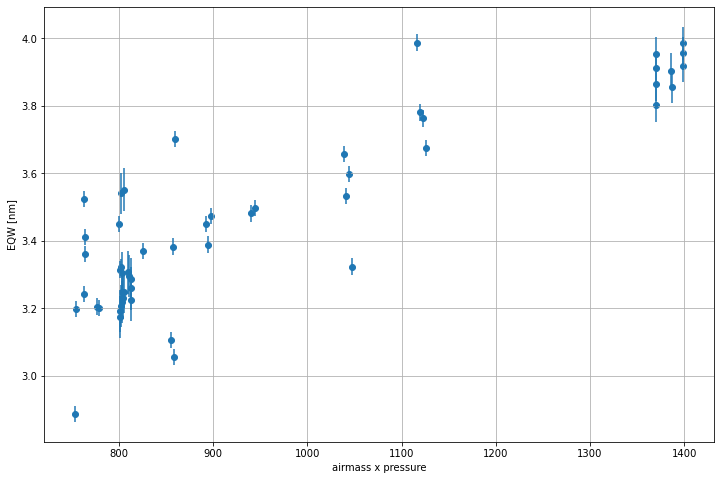

In [34]:
plt.figure(figsize=(12,8))
plt.scatter(airmass*pressure,eqwidth)
plt.errorbar(airmass*pressure,eqwidth,yerr=eqwidth_err,ls='',fmt='.')
plt.grid()
plt.xlabel('airmass x pressure')
plt.ylabel('EQW [nm]')

# Check EQW for extreme airmass values 

In [35]:
spec_dict_ext_am = {}
for key in spec_dict_good.keys():
    #if spec_dict_good[key]['airmass']>1.8:
    if spec_dict_good[key]['airmass']<1.2:
        spec_dict_ext_am[key] = spec_dict_good[key]

In [36]:
num_plots = len(spec_dict_ext_am.keys())
print(num_plots)

33


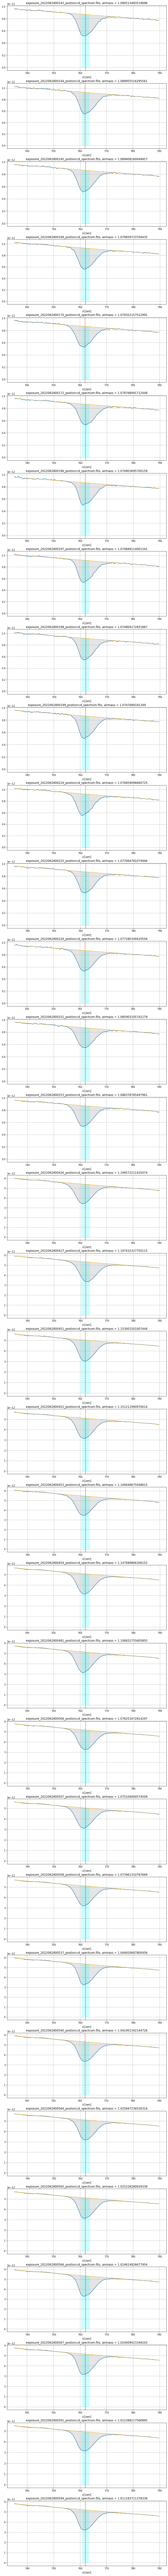

In [37]:
fig, axs = plt.subplots(num_plots, 1, figsize=(12,6*num_plots))
for i,spec in enumerate(list(spec_dict_ext_am.keys())):
    airmass_ = spec_dict_good[spec]['airmass']
    pressure_ = spec_dict_good[spec]['pressure']
    
    lambda_ = spec_dict_good[spec]['all_lambdas']
    flux_ = spec_dict_good[spec]['all_fluxes']
    
    eqw_, p, cov, xline, fline, ffit, ffit_model, linemask, xcontinuum, cont_at_line, area_l_, area_c_err_, continuum = eqw(lambda_,flux_,min_cont,max_cont,min_lin,max_lin,central_lambda=line_lambda,n_order=n_order,make_plot=False,return_fit=True)
    
    axs[i].plot(xline,fline)
    axs[i].plot(xline,ffit,ls='--',color='orange')
    axs[i].fill_between(xline[linemask],ffit_model,fline[linemask],color='gray',alpha=0.2)
    axs[i].fill_between(xcontinuum,continuum,color='cyan',alpha=0.2)
    axs[i].axvline(x=line_lambda,ls='--',color='r')
    axs[i].grid()
    axs[i].set_xlabel(r'$\lambda \, [nm]$',fontsize=12)
    axs[i].set_title(spec+', airmass = {0}'.format(airmass_))
    #axs[i].set_ylabel(r'$\gamma \, / \, (s \cdot cm^2 \cdot nm)$',fontsize=12)